# Лабораторная работа 2. Метод ближайших соседей и решающие деревья.

ФИО: Гурьянов Алексей Константинович

Группа: 517

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [70]:
from pylab import *

In [2]:
import numpy as np
import pandas as pd

Все эксперименты в этой лабораторной работе предлагается проводить на данных соревнования Amazon Employee Access Challenge: https://www.kaggle.com/c/amazon-employee-access-challenge

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

Для удобства данные можно загрузить по ссылке: https://www.dropbox.com/s/q6fbs1vvhd5kvek/amazon.csv

Сразу прочитаем данные и создадим разбиение на обучение и контроль:

In [3]:
DATA = pd.read_csv('amazon.csv')
DATA.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [4]:
DATA.shape

(32769, 10)

Так как в процессе выполнения первой части оказалось, что KNN без реализации кд-дерева работает очень медленно, первая часть была выполнена на первых 300 объектах выборки.

In [5]:
data = DATA.iloc[0:300, :].copy()

In [6]:
# доля положительных примеров
data.ACTION.mean()

0.93333333333333335

In [7]:
# число значений у признаков
for col_name in data.columns:
    print col_name, len(data[col_name].unique())

ACTION 2
RESOURCE 246
MGR_ID 275
ROLE_ROLLUP_1 48
ROLE_ROLLUP_2 65
ROLE_DEPTNAME 159
ROLE_TITLE 95
ROLE_FAMILY_DESC 154
ROLE_FAMILY 34
ROLE_CODE 95


In [8]:
from sklearn.cross_validation import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, 1:], data.iloc[:, 0],
                                                    test_size=0.3, random_state=241)

In [10]:
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

## Часть 1: kNN и категориальные признаки

#### 1. Реализуйте три функции расстояния на категориальных признаках, которые обсуждались на втором семинаре. Реализуйте самостоятельно метод k ближайших соседей, который будет уметь работать с этими функциями расстояния (учтите, что он должен возвращать вероятность — отношение объектов первого класса среди соседей к числу соседей). Как вариант, можно реализовать метрики как [user-defined distance](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html), после чего воспользоваться реализацией kNN из sklearn (в этом случае используйте функцию predict_proba).

#### Подсчитайте для каждой из метрик качество на тестовой выборке `X_test` при числе соседей $k = 10$. Мера качества — AUC-ROC.

Какая функция расстояния оказалась лучшей?

Во втором семинаре было разобрано три метрики расстояния над категориальными признаками. В следующих трех ячейках они реализованы в том же порядке в каком они указаны в конспектах лекции.

In [288]:
def dist1(x, y):
    return (x-y).apply(lambda a: int(a != 0)).mean()

In [289]:
def dist2(x, y, weights):
    A = (x-y).apply(lambda a: int(a != 0))
    B = np.array([int(x[i] == y[i]) * weights[i].get(x[i], 0) for i in x.index])
    return (A + B).mean()

In [321]:
def dist3(x, y, weights):
    return np.array([x[i] * y[i] * weights[i].get(x[i], 0) * weights[i].get(y[i], 0) for i in x.index]).mean()

Для выполнения задания было решено реализовать свой собственный knn. Далее расположен его код.

In [326]:
class MyKNN:
    def __init__(self, k, distance):
        self.k = k
        if distance == "type1" or distance == "type2" or distance == "type3":
            self.distance = distance
        else:
            raise ValueError('MyKNN does not support %s distance type.' % distance)
            
    def changeK(self, k):
        self.k = k
            
    def fit(self, X_train, y_train):
        self.X = X_train
        self.Y = y_train
        if self.distance == "type1":
            pass
        elif self.distance == "type2":
            self.weights = dict()
            
            for key in X_test.axes[1]:
                self.weights[key] = dict()
                value_counts = self.X[key].value_counts()
                l = value_counts.sum()
                stats = dict()
                for i in value_counts.index:
                    if value_counts[i] in stats:
                        stats[value_counts[i]].append(i)
                    else:
                        stats[value_counts[i]] = [i]
                s_stats = sorted(stats.items(), key=lambda t: t[0])
                p_j = np.array([float(entry[0] * (entry[0] - 1)) / (l * (l - 1)) for entry in s_stats])
                d = np.cumsum(p_j)
                for i in range(0, len(s_stats)):
                    for k in s_stats[i][1]:
                        self.weights[key][k] = d[i]
            pass
        elif self.distance == "type3":
            self.weights = dict()
            for key in X_test.axes[1]:
                self.weights[key] = dict(self.X[key].value_counts().apply(np.log2))
            pass
        else:
            pass           
        
    def predict(self, X_test):
        if self.distance == "type1":
            A = X_test.apply(lambda x: self.X.apply(lambda y: dist1(x, y), axis = 1), axis = 1)
            return A.apply(lambda z: self.Y[np.array(z.order().index[0:self.k])].mean(), axis = 1)
        elif self.distance == "type2":
            A = X_test.apply(lambda x: self.X.apply(lambda y: dist2(x, y, self.weights), axis = 1), axis = 1)
            return A.apply(lambda z: self.Y[np.array(z.order().index[0:self.k])].mean(), axis = 1)
        elif self.distance == "type3":
            A = X_test.apply(lambda x: self.X.apply(lambda y: dist3(x, y, self.weights), axis = 1), axis = 1)
            return A.apply(lambda z: self.Y[np.array(z.order().index[0:self.k])].mean(), axis = 1)
        else:
            return

Чтобы удостовериться, что выполнения задания всего лишь на 300 объектах необходимо, замерим время необходимое для одной итерации контроля.

In [292]:
import timeit
timeit.timeit('classifier.predict(X_test)', setup = "from __main__ import MyKNN, X_train, X_test, y_train; classifier = MyKNN(3, 'type1');classifier.fit(X_train, y_train)",number = 1)

7.035068035125732

7 секунд - очень большое время для одного процента входных данных. Так как время выполнения обучения/классификации KNN зависит от количества объектов как квадратичная функция, время выполнения одной итерации на всей выборке превышало бы 70000 секунд - более полутора месяцев. Значит дальнейшую часть первых двух пунктов будем выполнять на урезанной выборке.

In [293]:
clf_t1_k10 = MyKNN(10, 'type1')
clf_t1_k10.fit(X_train, y_train)
t1_k10 = clf_t1_k10.predict(X_test)

In [294]:
clf_t2_k10 = MyKNN(10, 'type2')
clf_t2_k10.fit(X_train, y_train)
t2_k10 = clf_t2_k10.predict(X_test)

In [295]:
clf_t3_k10 = MyKNN(10, 'type3')
clf_t3_k10.fit(X_train, y_train)
t3_k10 = clf_t3_k10.predict(X_test)

In [296]:
AUCScore_t1 = roc_auc_score(y_test, t1_k10)

In [297]:
AUCScore_t2 = roc_auc_score(y_test, t2_k10)

In [298]:
AUCScore_t3 = roc_auc_score(y_test, t3_k10)

In [299]:
print "type 1 AUC: ", AUCScore_t1
print "type 2 AUC: ", AUCScore_t2
print "type 3 AUC: ", AUCScore_t3

type 1 AUC:  0.689655172414
type 2 AUC:  0.739463601533
type 3 AUC:  0.45785440613


Для 10 ближайших соседей вторая функция расстояния оказалась наилучшей с оценкой AUC 0.73

#### 2 (бонус). Подберите лучшее (на тестовой выборке) число соседей $k$ для каждой из функций расстояния. Какое наилучшее качество удалось достичь?

In [316]:
def ScoreKNN(distType, k_range, X_train, X_test, y_train, y_test):
    answers = []
    clf = MyKNN(0, distType)
    clf.fit(X_train, y_train)
    for k in k_range:
        clf.changeK(k)
        y_answer = clf.predict(X_test)
        AUCScore = roc_auc_score(y_test, y_answer)
        answers.append(AUCScore)
        
    return answers

In [307]:
answers_t1 = ScoreKNN('type1', range(1, 35), X_train, X_test, y_train, y_test)

In [327]:
answers_t2 = ScoreKNN('type2', range(1, 35), X_train, X_test, y_train, y_test)

In [328]:
answers_t3 = ScoreKNN('type3', range(1, 35), X_train, X_test, y_train, y_test)

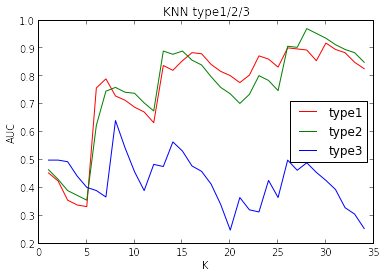

In [329]:
plot(range(1, 35), answers_t1, 'r', label = 'type1')
plot(range(1, 35), answers_t2, 'g', label = 'type2')
plot(range(1, 35), answers_t3, 'b', label = 'type3')
legend(loc = 0)
xlabel('K')
ylabel('AUC')
title('KNN type1/2/3')
show()

In [311]:
t1_best_id = np.array(answers_t1).argmax()
t1_best = answers_t1[t1_best_id]
t1 = (t1_best_id + 1, t1_best)

In [312]:
t2_best_id = np.array(answers_t2).argmax()
t2_best = answers_t2[t2_best_id]
t2 = (t2_best_id + 1, t2_best)

In [313]:
t3_best_id = np.array(answers_t3).argmax()
t3_best = answers_t3[t3_best_id]
t3 = (t3_best_id + 1, t3_best)

In [314]:
print "type 1 best AUC: ", t1
print "type 2 best AUC: ", t2
print "type 3 best AUC: ", t3

type 1 best AUC:  (30, 0.91954022988505746)
type 2 best AUC:  (28, 0.97126436781609193)
type 3 best AUC:  (8, 0.64176245210727978)


Лучшее качество получилось у второй метрике с 28 ближайшими соседями, его AUC оценка равна 0.971.
Стоит отметить, что третья метрика проявила себя очень плохо, в основном показывая оценку даже меньше 0.5, что для AUC является показателем очень плохого алгоритма.

#### 3. Реализуйте счетчики (http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx), которые заменят категориальные признаки на вещественные.

А именно, каждый категориальный признак нужно заменить на три: 
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `clicks` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`clicks` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `clicks` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанный по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

#### Посчитайте на тесте AUC-ROC метода $k$ ближайших соседей с евклидовой метрикой для выборки, где категориальные признаки заменены на счетчики. Сравните по AUC-ROC два варианта формирования выборки — с фолдингом и без. Не забудьте подобрать наилучшее число соседей $k$.

Так как в этом задании необходимо пользоваться евклидовой метрикой, то нет смысла работать с собственной реализацией KNN без кд-дерева. В этом и последующих пунктах работа проводилась на полной выборке.

In [11]:
def clickTransform(data_stats, data_transform, target):
    data_c = data_transform.copy()
    if target not in data_c.columns:
        return
    for col in data_c.columns:
        if col == target:
            continue
        clicks = data_c[col].map(data_stats[col][data_stats[target] == 1].value_counts()).fillna(0)
        counts = data_c[col].map(data_stats[col].value_counts()).fillna(0)
        divs = (clicks + 1).divide((counts + 2), fill_value = 0)
        data_c[col + "_clicks"] = clicks
        data_c[col + "_counts"] = counts
        data_c[col + "_divs"] = divs
        data_c = data_c.drop(col, axis = 1)
        
    return data_c

In [61]:
def clickFoldingTransform(data, target, n):
    data_c = data.copy()
    colList = data_c.columns
    
    if target not in colList:
        return
    
    foldCol = "__FOLD__"
    foldSize = (data_c.shape[0] + n - 1) / n 
    serValues = np.tile(np.arange(0, n), foldSize)[0:data_c.shape[0]]
    np.random.shuffle(serValues)
    data_c[foldCol] = pd.Series(serValues, index = data_c.index)
    
    cl_list = dict()
    cn_list = dict()
    div_list = dict()
    
    for col in colList:
        cl_list[col] = []
        cn_list[col] = []
        div_list[col] = []
    
    for i in range(0, n):
        unfold = data_c[data_c[foldCol] != i]
        fold = data_c[data_c[foldCol] == i]
        for col in colList:
            if col == target:
                continue
            
            clicks = fold[col].map(unfold[col][unfold[target] == 1].value_counts()).fillna(0)
            counts = fold[col].map(unfold[col].value_counts()).fillna(0)
            divs = (clicks + 1).divide((counts + 2), fill_value = 0)
            
            cl_list[col].append(clicks)
            cn_list[col].append(counts)
            div_list[col].append(divs)
            
    for col in colList:
        if col == target:
            continue

        data_c[col + "_clicks"] = pd.concat(cl_list[col])
        data_c[col + "_counts"] = pd.concat(cn_list[col])
        data_c[col + "_divs"] = pd.concat(div_list[col])
        data_c = data_c.drop(col, axis = 1)
        
    data_c = data_c.drop(foldCol, axis = 1)
           
    return data_c

In [62]:
def fold_click(D_train, D_test, target,n):
    d_tr = clickFoldingTransform(D_train, target, n)
    X_train = d_tr.iloc[:, 1:]
    y_train = d_tr.iloc[:, 0]
    d_tst = clickTransform(D_train, D_test, target)
    X_test = d_tst.iloc[:, 1:]
    y_test = d_tst.iloc[:, 0]
    
    return X_train, X_test, y_train, y_test

In [63]:
def nofold_click(D_train, D_test, target):
    d_tr = clickTransform(D_train, D_train, target)
    X_train = d_tr.iloc[:, 1:]
    y_train = d_tr.iloc[:, 0]
    d_tst = clickTransform(D_train, D_test, target)
    X_test = d_tst.iloc[:, 1:]
    y_test = d_tst.iloc[:, 0]

    return X_train, X_test, y_train, y_test   

In [110]:
def KNNEval (X_train, X_test, y_train, y_test, k_range):
    fold_results = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k, metric = "euclidean")
        knn.fit(X_train, y_train)
        y_answer = [p[1] for p in knn.predict_proba(X_test)]
        fold_results.append(roc_auc_score(y_test, y_answer))
        
    return fold_results

После реализации основных методов можно посмотреть, что они работают.

In [65]:
D_train, D_test = train_test_split(DATA.iloc[:, :], test_size=0.3, random_state=241)

In [66]:
Xf_train, Xf_test, yf_train, yf_test = fold_click(D_train, D_test, "ACTION", 3)
fold_results = KNNEval(Xf_train, Xf_test, yf_train, yf_test, range(1, 35))

In [35]:
Xnf_train, Xnf_test, ynf_train, ynf_test = nofold_click(D_train, D_test, "ACTION")
nofold_results = KNNEval(Xnf_train, Xnf_test, ynf_train, ynf_test, range(1, 35))

In [91]:
def analyseKNNFolding(D_train, D_test, n, k_range):
    Xf_train, Xf_test, yf_train, yf_test = fold_click(D_train, D_test, "ACTION", n)
    fold_results = KNNEval(Xf_train, Xf_test, yf_train, yf_test, k_range)
    
    Xnf_train, Xnf_test, ynf_train, ynf_test = nofold_click(D_train, D_test, "ACTION")
    nofold_results = KNNEval(Xnf_train, Xnf_test, ynf_train, ynf_test, k_range)
    
    plot(k_range, fold_results, 'r', label = 'KNN + click with folding')
    plot(k_range, nofold_results, 'g', label = 'KNN + click w/o folding')
    legend(loc = 0)
    xlabel('K')
    ylabel('AUC')
    title('KNN with ' + str(n) + '-fold clicks.')
    show()
    
    best_fold = np.array(fold_results).argmax()
    best_nofold = np.array(nofold_results).argmax()                     
    print "Best KNN with folding quality: k =", best_fold, ", AUC =" , fold_results[best_fold]
    print "Best KNN w/o folding quality: k =", best_nofold, ", AUC =" , nofold_results[best_nofold]

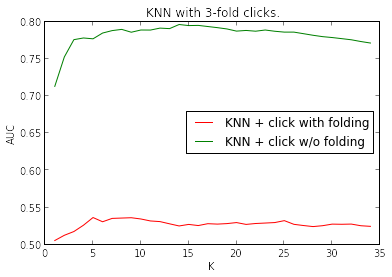

Best KNN with folding quality: k = 4 , AUC = 0.53664544637
Best KNN w/o folding quality: k = 13 , AUC = 0.796091066126


In [85]:
analyseKNNFolding(D_train, D_test, 3, range(1, 35))

Результат на алгоритме с тремя фолдами получился очень плохим. Скорее всего это происходит из-за того что полностью теряется информация о значениях признаков с немногочисленными представителями таких значений. Проверим работу алгоритма для большего количества фолдов.

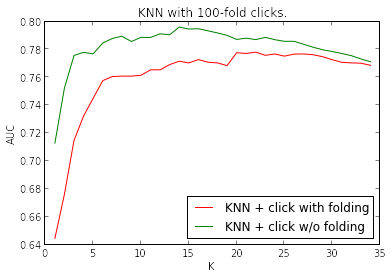

Best KNN with folding quality: k = 21 , AUC = 0.778085443322
Best KNN w/o folding quality: k = 13 , AUC = 0.796091066126


In [86]:
analyseKNNFolding(D_train, D_test, 100, range(1, 35))

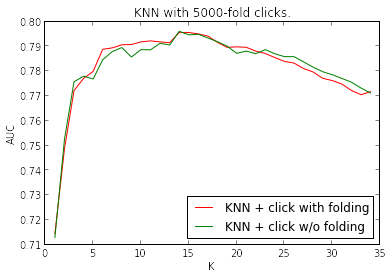

Best KNN with folding quality: k = 13 , AUC = 0.795639721491
Best KNN w/o folding quality: k = 13 , AUC = 0.796091066126


In [87]:
analyseKNNFolding(D_train, D_test, 5000, range(1, 35))

Заметно, что при увеличении количества фолдов разница между методами сокращается, причем метод с фолдами даже начинает местами превосходить метод без фолдов.

#### 4. Добавьте в исходную выборку парные признаки — то есть для каждой пары $f_i$, $f_j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$. Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

In [104]:
def addPairFeatures(data, target):
    data_ans = data.copy()
    
    columns = [x for x in data_ans.columns if x != target]
    data_ans = data_ans.applymap(str)
    data_ans[target] = data_ans[target].apply(int)
    
    length = len(columns)
    
    for i in range(0, length):
        for k in range(i + 1, length): 
            data_ans[columns[i] + "|" + columns[k]] = data_ans[columns[i]] + data_ans[columns[k]]
            
    return data_ans

In [105]:
Pairs = addPairFeatures(DATA, "ACTION")

In [106]:
Dp_train, Dp_test = train_test_split(Pairs.iloc[:, :], test_size=0.3, random_state=241)

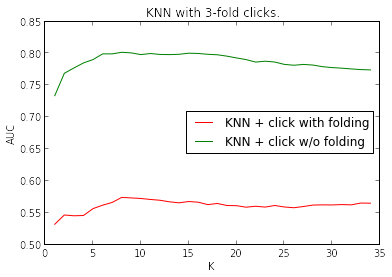

Best KNN with folding quality: k = 7 , AUC = 0.574336721967
Best KNN w/o folding quality: k = 7 , AUC = 0.801859076241


In [111]:
analyseKNNFolding(Dp_train, Dp_test, 3, range(1, 35))

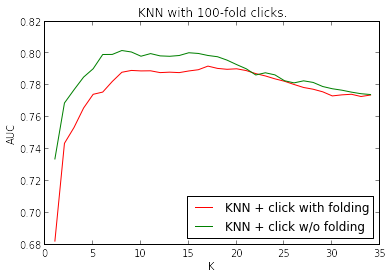

Best KNN with folding quality: k = 16 , AUC = 0.792082608199
Best KNN w/o folding quality: k = 7 , AUC = 0.801859076241


In [112]:
analyseKNNFolding(Dp_train, Dp_test, 100, range(1, 35))

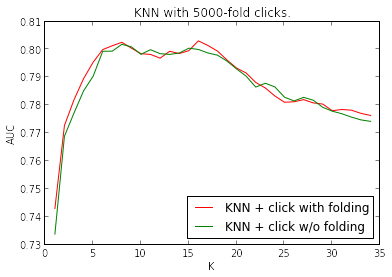

Best KNN with folding quality: k = 15 , AUC = 0.803091715243
Best KNN w/o folding quality: k = 7 , AUC = 0.801859076241


In [113]:
analyseKNNFolding(Dp_train, Dp_test, 5000, range(1, 35))

После использования парных признаков ничего принципиально не изменилось.

## Часть 2: Решающие деревья и леса

#### 1. Возьмите из предыдущей части выборку с парными признаками, преобразованную с помощью счетчиков без фолдинга. Настройте решающее дерево, подобрав оптимальные значения параметров `max_depth` и `min_samples_leaf`. Какой наилучший AUC-ROC на контроле удалось получить?

In [192]:
from sklearn import tree
from matplotlib.colorbar import make_axes

Так как генерация дерева занимает много времени, то оптимизация параметра будет проходить по решетке с большим шагом. В данном случае это не критично так как картинка не сильно меняется с уменьшением шага. 
Можно было бы воспользоваться реализованным в sklearn GridSearchCV для перебора параметров по решетке, но для данного простого случая было решено этого не делать.

In [336]:
Xpnnf_train, Xpnnf_test, ypnnf_train, ypnnf_test = nofold_click(Dp_train, Dp_test, "ACTION")

In [337]:
MSLrange = range(1, 2501, 50)
MDrange = range(1, 100, 5)
tot_ans = []
for k in MSLrange:
    ans = []
    for l in MDrange:
        DTclf = tree.DecisionTreeClassifier(min_samples_leaf = k, max_depth = l)
        DTclf.fit(Xpnnf_train, ypnnf_train)
        y_answer = [p[1] for p in DTclf.predict_proba(Xpnnf_test)]
        ans.append(roc_auc_score(ypnnf_test, y_answer))
        
    tot_ans.append(ans)

In [338]:
zvals = np.array(tot_ans)

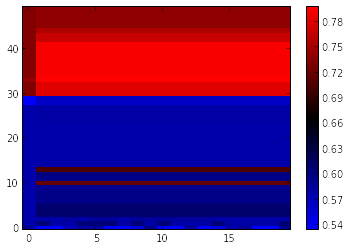

In [339]:
from matplotlib import mpl,pyplot

cmap2 = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', ['blue','black','red'], 256)

img2 = pyplot.imshow(zvals,interpolation='nearest', cmap = cmap2, origin='lower', aspect = 'auto')

colorbarplot = pyplot.colorbar(img2,cmap=cmap2)

In [340]:
np.where(zvals >= zvals.max())

(array([33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19]))

In [341]:
print zvals.max()

0.797965903038


Максимальное значение получилось 0.797, оно достигается при максимальной глубине более 6 и минимальным количеством объектов в листе равном 1651.

#### 2. Настройте случайный лес, подобрав оптимальное число деревьев `n_estimators`. Какое качество на тестовой выборке он дает?

In [266]:
from sklearn.ensemble import RandomForestClassifier

In [342]:
k_range = range(1, 80, 1)
rf_ans = []
for i in k_range:
    clf = RandomForestClassifier(n_estimators = i, random_state = 241)
    clf.fit(Xpnnf_train, ypnnf_train)
    y_answer = [p[1] for p in clf.predict_proba(Xpnnf_test)]
    rf_ans.append(roc_auc_score(ypnnf_test, y_answer))

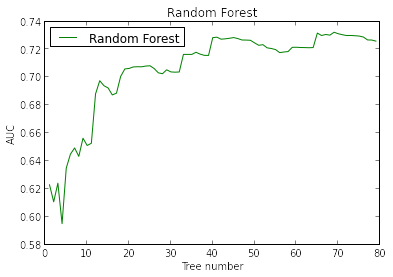

In [343]:
plot(k_range, rf_ans, 'g', label = 'Random Forest')
legend(loc = 0)
xlabel('Tree number')
ylabel('AUC')
title('Random Forest')
show()

In [344]:
print np.array(rf_ans).argmax(), np.array(rf_ans).max()

68 0.732373837359


Случайный лес дает лучшее качество 0.73 AUC при 68деревьях.

#### 3. Возьмите выборку с парными признаками, для которой счетчики посчитаны с фолдингом. Обучите на ней случайный лес, подобрав число деревьев. Какое качество на тестовой выборке он дает? Чем вы можете объяснить изменение результата по сравнению с предыдущим пунктом?

In [284]:
Xpnf_train, Xpnf_test, ypnf_train, ypnf_test = fold_click(Dp_train, Dp_test, "ACTION", 3)

In [335]:
k_range = range(1, 80, 1)
rpnff_ans = []
for i in k_range:
    clf = RandomForestClassifier(n_estimators = i, random_state = 241)
    clf.fit(Xpnf_train, ypnf_train)
    y_answer = [p[1] for p in clf.predict_proba(Xpnf_test)]
    rpnff_ans.append(roc_auc_score(ypnf_test, y_answer))

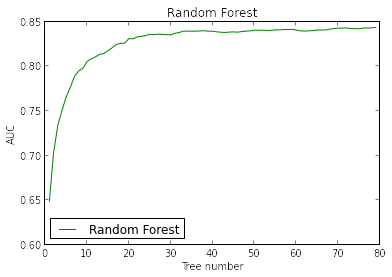

In [333]:
plot(k_range, rpnff_ans, 'g', label = 'Random Forest')
legend(loc = 0)
xlabel('Tree number')
ylabel('AUC')
title('Random Forest')
show()

In [287]:
print np.array(rpnff_ans).argmax(), np.array(rpnff_ans).max()

78 0.843544792293


Алгоритм дает значительно лучшее качество, почти на 0.1 практически на всех количествах деревьев. Лучшее качество было достигнуто на 78 деревьях и оно равно 0.84 AUC. Причина такого повышения качества ввергают меня в недоумение, особенно после того как обнаружилось, что техника фолдов с малым количеством фолдов очень резко снижает качество классификаци. Придумать причину, которая применялась бы к случайному лесу но не применялась к KNN у меня не получилось.